<a href="https://colab.research.google.com/github/nathan79-c/4425126-testing-python/blob/master/TP_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nous allons utiliser les LSTM pour prédire les charges de service futures pour une semaine. Le fichier d'exercice pour ce chapitre est code_05_XX Forecasting Service Loads. Le fichier de données pour cet exercice est request_every_hour.csv. Considérons que nous avons un service web qui s'exécute dans un réseau et qui répond aux requêtes de ses clients. Le nombre de requêtes traitées par ce service varie en fonction de l'heure et du jour de la semaine. Ce fichier contient le nombre total de demandes que ce service reçoit chaque heure. Il contient ces valeurs pour une période de cinq semaines, chaque semaine commençant un lundi. Ce fichier contient 840 valeurs, une pour chaque heure au cours de ces cinq semaines. Nous devons utiliser ces données et prédire la charge du service pour chaque heure de la sixième semaine. En d'autres termes, nous devons prédire une semaine entière par heure, ce qui représente 168 prédictions. Commençons par charger ce fichier de données dans un cadre de données.  Nous chargeons le fichier et affichons ensuite quelques données pour vérifier que le chargement est correct.

In [9]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Chargement des données de la série chronologique

Les données représentent le total horaire des demandes de service pour 5 semaines, en commençant par le lundi.


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1)

#Load the sequence data from CSV
requests = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/requests_every_hour.csv',header=0)

#Review loaded data
print(requests.dtypes)
requests.head()

Requests    int64
dtype: object


,Requests
0,100
1,113
2,162
3,186
4,228


# Modèles de séries chronologiques
Une série chronologique peut présenter des schémas cycliques, saisonniers et de croissance.

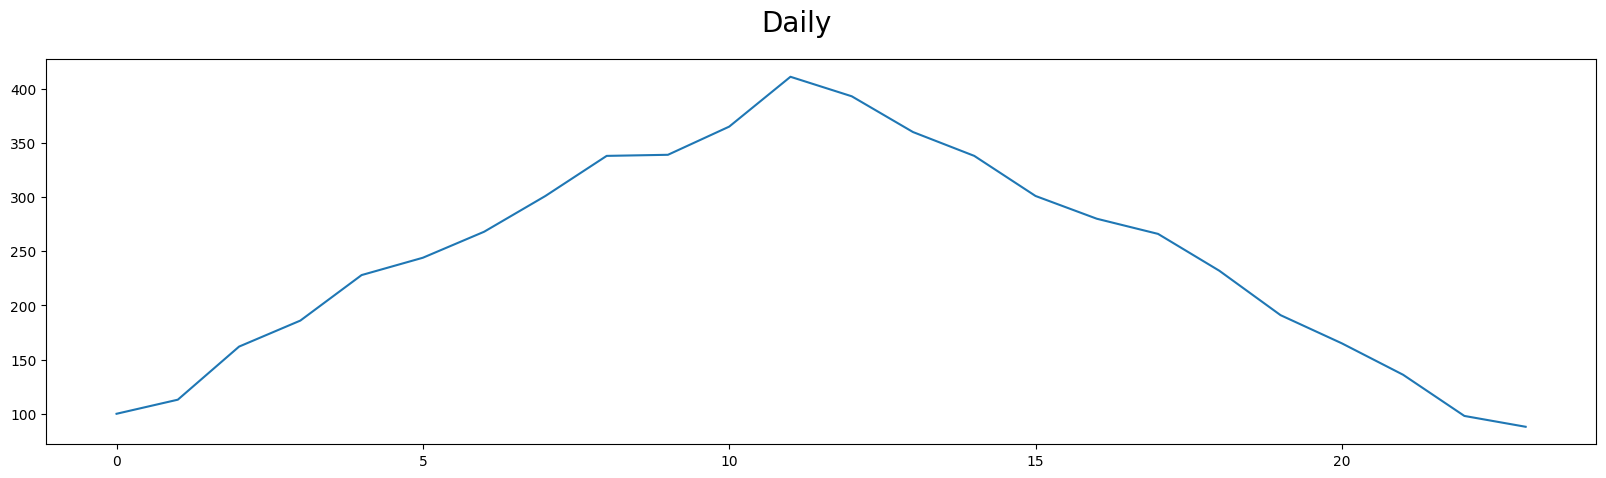

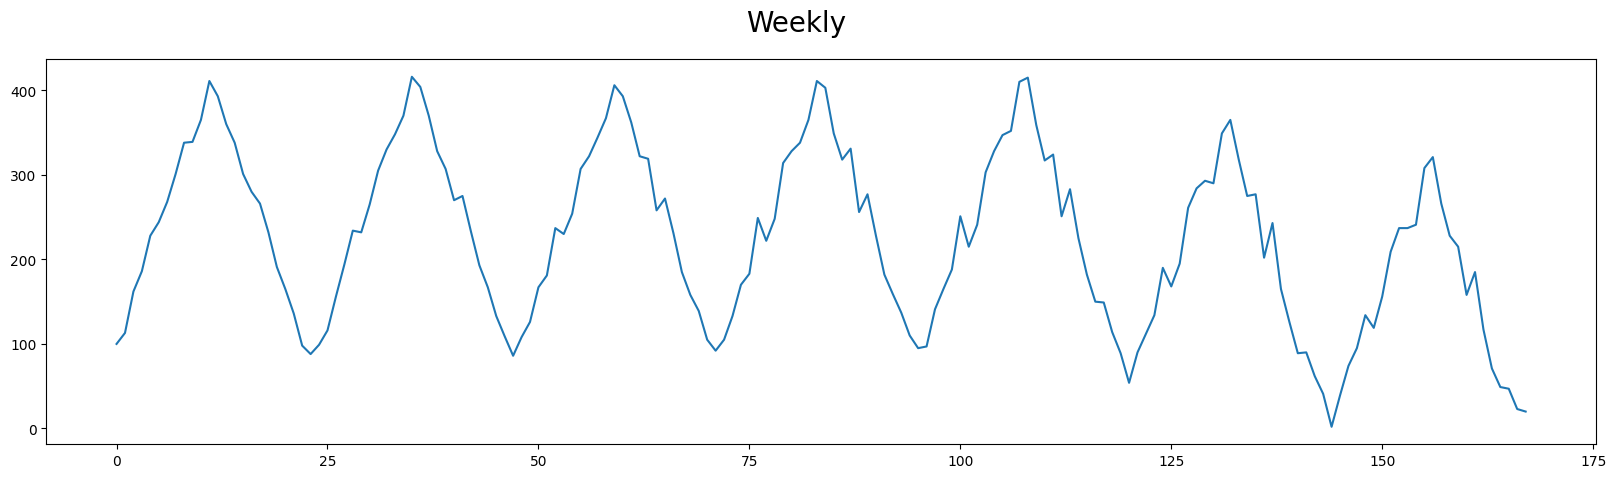

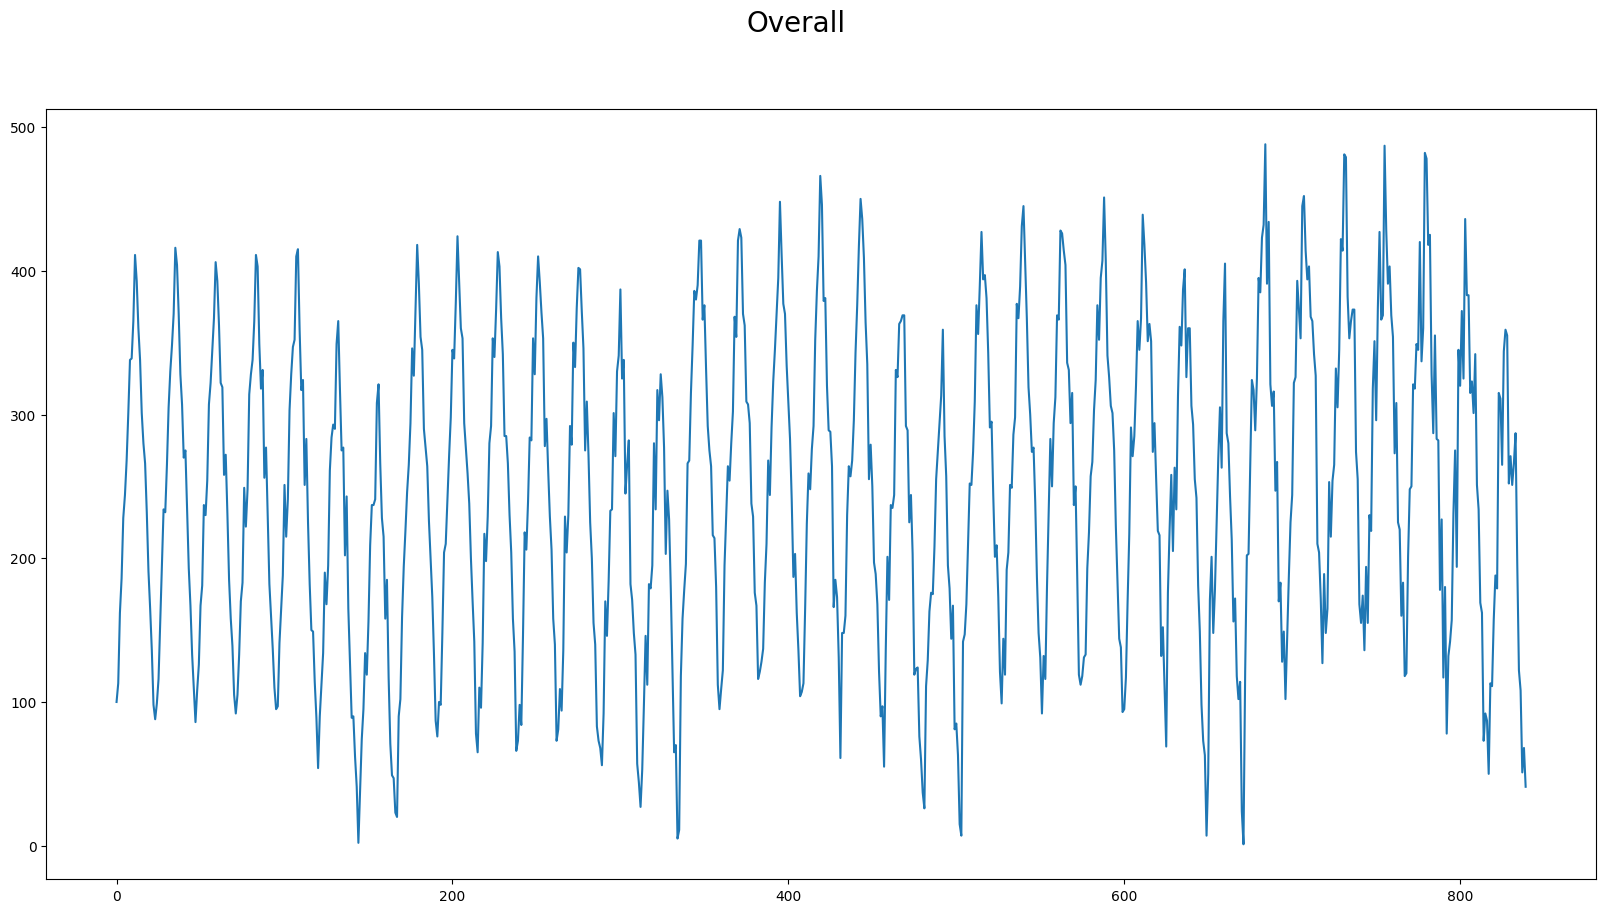

In [12]:
#Plat the data loaded to visualize trends
#daily

plt.figure(figsize=(20,5)).suptitle("Daily", fontsize=20)
plt.plot(requests.head(24))
plt.show()

#weekly
plt.figure(figsize=(20,5)).suptitle("Weekly", fontsize=20)
plt.plot(requests.head(168))
plt.show()

#all
plt.figure(figsize=(20,10)).suptitle("Overall", fontsize=20)
plt.plot(requests)
plt.show()

# Préparation des données de séries temporelles

Nous utiliserons les quatre premières semaines de données comme données d'entraînement et la dernière semaine comme données de test. Notez que pour les données séquentielles, nous ne pouvons pas utiliser la division aléatoire comme nous le faisons pour l'apprentissage automatique normal. Ensuite, nous allons définir la période de retour en arrière pour une semaine entière. Nous devons procéder ainsi pour pouvoir capturer les diverses tendances cycliques et saisonnières des données.

In [13]:
from sklearn.preprocessing import StandardScaler

#Scale the data
print("Request Range before scaling : " ,
          min(requests.Requests),
          max(requests.Requests))

scaler = StandardScaler()
scaled_requests=scaler.fit_transform(requests)
print("Request Range after scaling : " ,
          min(scaled_requests),
          max(scaled_requests))

#Training data has to be sequencial - first 4 weeks
train_size = 24 * 7 * 4

#Number of samples to lookback for each sample
lookback=24 * 7

#Separate training and test data
train_requests = scaled_requests[0:train_size,:]

#Add an additional week for lookback.
test_requests = scaled_requests[train_size-lookback:,:]

print("\n Shaped of Train, Test : ",
      train_requests.shape, test_requests.shape)

Request Range before scaling :  1 488
Request Range after scaling :  [-2.28221282] [2.23748868]

 Shaped of Train, Test :  (672, 1) (336, 1)


In [14]:
#Prepare RNN Dataset.
#Each data point (X) is linked to the previous data points of size=lookback
#The predicted value (Y) is the next point

def create_rnn_dataset(data, lookback=1):

    data_x, data_y = [], []
    for i in range(len(data)- lookback -1):
            #All points from this point, looking backwards upto lookback
            a = data[i:(i+ lookback), 0]
            data_x.append(a)
            #The next point
            data_y.append(data[i + lookback, 0])
    return np.array(data_x), np.array(data_y)

#Create X and Y for training
train_req_x, train_req_y = create_rnn_dataset(train_requests,lookback)

#Reshape for use with LSTM
train_req_x = np.reshape(train_req_x,
                         (train_req_x.shape[0],1, train_req_x.shape[1]))

print("Shapes of X, Y: ",train_req_x.shape, train_req_y.shape)

Shapes of X, Y:  (503, 1, 168) (503,)


La seule différence est que nous utiliserons une couche LSTM au lieu d'une simple couche RNN. Nous commençons par construire un modèle séquentiel. Nous ajoutons une couche LSTM à ce modèle. Enfin, nous ajoutons une couche dense pour la sortie. Nous compilons ensuite le modèle avec une fonction de perte, un optimiseur et des métriques

In [15]:
from keras.models import Sequential
from keras.layers import LSTM,Dense
import tensorflow as tf

tf.random.set_seed(3)

#Create a Keras Model
ts_model=Sequential()
#Add LSTM
ts_model.add(LSTM(256, input_shape=(1,lookback)))
ts_model.add(Dense(1))

#Compile with Adam Optimizer. Optimize for minimum mean square error
ts_model.compile(loss="mean_squared_error",
                 optimizer="adam",
                 metrics=["mse"])

#Print model summary
ts_model.summary()

#Train the model
ts_model.fit(train_req_x, train_req_y,
             epochs=5, batch_size=1, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               435200    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 435457 (1.66 MB)
Trainable params: 435457 (1.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
503/503 [==============================] - 6s 8ms/step - loss: 0.1474 - mse: 0.1474
Epoch 2/5
503/503 [==============================] - 3s 6ms/step - loss: 0.0771 - mse: 0.0771
Epoch 3/5
503/503 [==============================] - 3s 6ms/step - loss: 0.0674 - mse: 0.0674
Epoch 4/5
503/503 [==============================] - 3s 6ms/step - loss: 0.0503 - mse: 0.0503
Epoch 5/5
503/503 [=====================

In [16]:
#Preprocess the test dataset, the same way training set is processed
test_req_x, test_req_y = create_rnn_dataset(test_requests,lookback)
test_req_x = np.reshape(test_req_x,
                         (test_req_x.shape[0],1, test_req_x.shape[1]))

#Evaluate the model
ts_model.evaluate(test_req_x, test_req_y, verbose=1)

#Predict for the training dataset
predict_on_train= ts_model.predict(train_req_x)
#Predict on the test dataset
predict_on_test = ts_model.predict(test_req_x)

#Inverse the scaling to view results
predict_on_train = scaler.inverse_transform(predict_on_train)
predict_on_test = scaler.inverse_transform(predict_on_test)

6/6 [==============================] - 0s 4ms/step


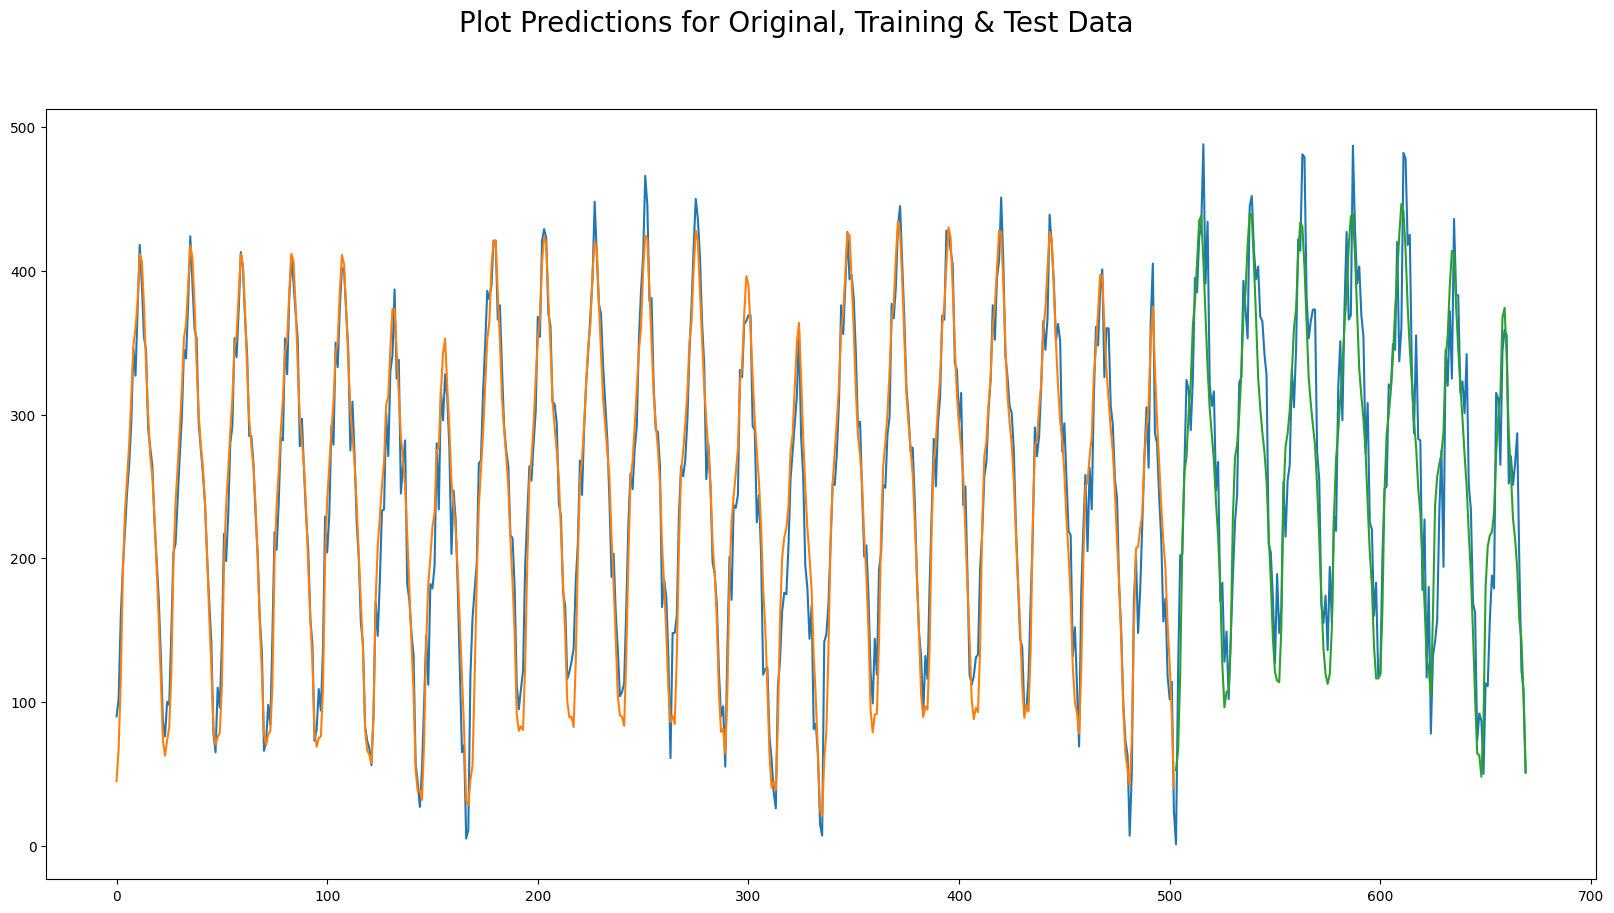

In [17]:
#Plot the predictions

#Total size of plot
total_size = len(predict_on_train) + len(predict_on_test)

#Plot original data
orig_data=requests.Requests.to_numpy()
orig_data=orig_data.reshape(len(orig_data),1)

#Create a plot for original data
orig_plot = np.empty((total_size,1))
orig_plot[:, :] = np.nan
orig_plot[0:total_size, :] = orig_data[lookback:-2,]

#Create a plot for predictions on training
predict_train_plot = np.empty((total_size,1))
predict_train_plot[:, :] = np.nan
predict_train_plot[0:len(predict_on_train), :] = predict_on_train

#Create a plot for predictions on testing
predict_test_plot = np.empty((total_size,1))
predict_test_plot[:, :] = np.nan
predict_test_plot[len(predict_on_train):total_size, :] = predict_on_test

#Plot the graphs
plt.figure(figsize=(20,10)).suptitle("Plot Predictions for Original, Training & Test Data", fontsize=20)
plt.plot(orig_plot)
plt.plot(predict_train_plot)
plt.plot(predict_test_plot)
plt.show()

In [18]:
#Use last part of the training data as the initial lookback
curr_input= test_req_x[-1,:].flatten()

#Predict for the next week
predict_for = 24 * 7

for i in range(predict_for):

    #Take the last lookback no. of samples as X
    this_input=curr_input[-lookback:]
    #Create the input
    this_input=this_input.reshape((1,1,lookback))
    #Predict for the next point
    this_prediction=ts_model.predict(this_input)

    #Add the current prediction to the input
    curr_input = np.append(curr_input,this_prediction.flatten())

#Extract the last predict_for part of curr_input, which contains all the new predictions
predict_on_future=np.reshape(np.array(curr_input[-predict_for:]),(predict_for,1))

# #Inverse to view results
predict_on_future=scaler.inverse_transform(predict_on_future)

print(predict_on_future[:5])

1/1 [==============================] - 0s 21ms/step
[[ 50.87085153]
 [ 49.10649468]
 [ 73.53006733]
 [ 85.92586909]
 [150.07208159]]


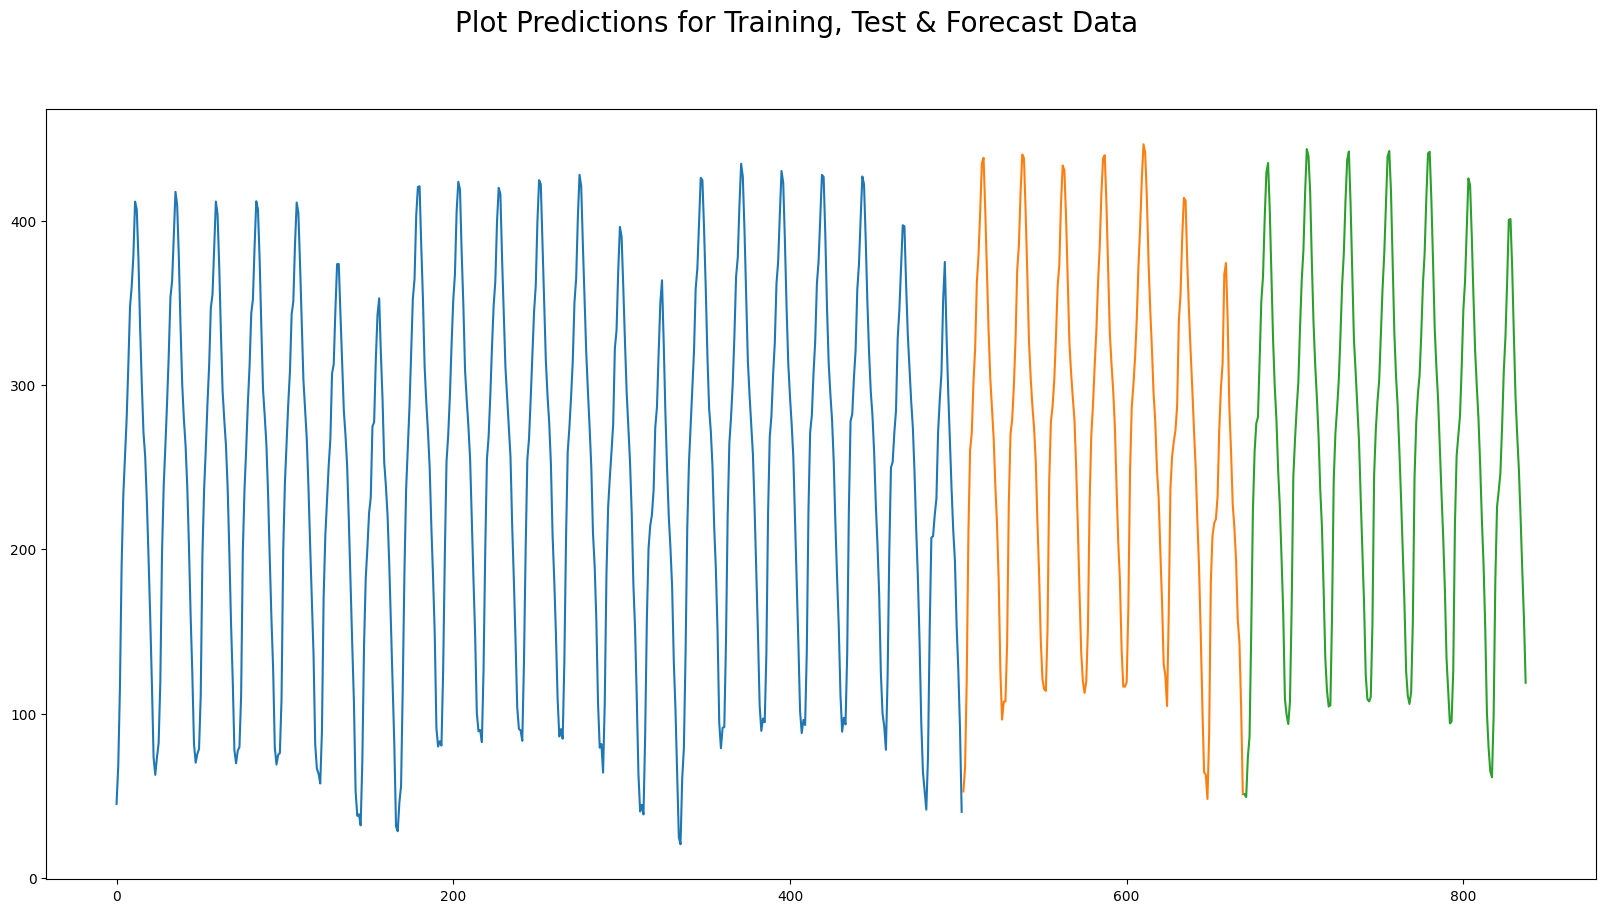

In [19]:
#Plot the training data with the forecast data
total_size = len(predict_on_train) + len(predict_on_test) + len(predict_on_future)

#Setup training chart
predict_train_plot = np.empty((total_size,1))
predict_train_plot[:, :] = np.nan
predict_train_plot[0:len(predict_on_train), :] = predict_on_train

#Setup test chart
predict_test_plot = np.empty((total_size,1))
predict_test_plot[:, :] = np.nan
predict_test_plot[len(predict_on_train):len(predict_on_train)+len(predict_on_test), :] = predict_on_test

#Setup future forecast chart
predict_future_plot = np.empty((total_size,1))
predict_future_plot[:, :] = np.nan
predict_future_plot[len(predict_on_train)+len(predict_on_test):total_size, :] = predict_on_future

plt.figure(figsize=(20,10)).suptitle("Plot Predictions for Training, Test & Forecast Data", fontsize=20)
plt.plot(predict_train_plot)
plt.plot(predict_test_plot)
plt.plot(predict_future_plot)
plt.show()